Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ipywidgets as widgets
from ipywidgets.widgets import interact
from IPython.display import display


Loading Data And Cleaning 

In [6]:
data = pd.read_csv("C:/Users/user/Desktop/Cyclic_BikeShare/Cyclic Dataset/Bikeshare_Raw.csv.csv")

data.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9340B064F0AEE130,electric_bike,2023-07-23 20:06:14,2023-07-23 20:22:44,Kedzie Ave & 110th St,20204,Public Rack - Racine Ave & 109th Pl,877,41.692406,-87.700905,41.694835,-87.653041,member
1,D1460EE3CE0D8AF8,classic_bike,2023-07-23 17:05:07,2023-07-23 17:18:37,Western Ave & Walton St,KA1504000103,Milwaukee Ave & Grand Ave,13033,41.898418,-87.686596,41.891578,-87.648384,member
2,DF41BE31B895A25E,classic_bike,2023-07-23 10:14:53,2023-07-23 10:24:29,Western Ave & Walton St,KA1504000103,Damen Ave & Pierce Ave,TA1305000041,41.898418,-87.686596,41.909396,-87.677692,member
3,9624A293749EF703,electric_bike,2023-07-21 08:27:44,2023-07-21 08:32:40,Racine Ave & Randolph St,13155,Clinton St & Madison St,TA1305000032,41.884112,-87.656943,41.882752,-87.641190,member
4,2F68A6A4CDB4C99A,classic_bike,2023-07-08 15:46:42,2023-07-08 15:58:08,Clark St & Leland Ave,TA1309000014,Montrose Harbor,TA1308000012,41.967088,-87.667291,41.963982,-87.638181,member


In [9]:
data.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    122943
start_station_id      122943
end_station_name      130304
end_station_id        130304
start_lat                  0
start_lng                  0
end_lat                 1254
end_lng                 1254
member_casual              0
dtype: int64

In [11]:
# Fill missing values in start_station_name and end_station_name with a placeholder value
data['start_station_name'].fillna('Unknown', inplace=True)
data['end_station_name'].fillna('Unknown', inplace=True)


Data Engineering and Transformation

In [12]:
#Rename columns 
data.rename(columns={'started_at':'start_time', 'ended_at': 'ended_time'}, inplace=True)

#calculating Ride Duration In Minutes 
data['ride_duration'] = (pd.to_datetime(data['ended_time']) - pd.to_datetime(data['start_time'])).dt.total_seconds()/60  #converting seconds to minutes

#Extracting Day of Week
data['weekday'] = (pd.to_datetime(data['start_time']).dt.day_name())


#calculating Distance in Kilometer
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius = 6371.0  # Earth radius in kilometers

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c  # Distance in kilometers

    return distance

data['ride_distance_km'] = data.apply(lambda row: calculate_distance(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']), axis=1)


#Calculating the Speed in Kilometer per hour 
data['speed_kph'] = data['ride_distance_km'] / (data['ride_duration'] / 60)

#Filtering data to seperate annual members and casual riders 
annual_members = data[data['member_casual']=='member']
casual_riders = data[data['member_casual']=='casual']
member_ride_count = annual_members['rideable_type'].value_counts()
casual_ride_count = casual_riders['rideable_type'].value_counts()





Data Analysis

In [14]:
# Calculate average ride duration by annual members and casual riders
average_duration_member = annual_members['ride_duration'].mean()
average_duration_casual = casual_riders['ride_duration'].mean()

# Calculate ride count by day of the week
ride_by_day = data['weekday'].value_counts()
member_ride_by_day = annual_members['weekday'].value_counts()
member_ride_by_day



weekday
Monday       73698
Saturday     66014
Thursday     65363
Tuesday      60460
Friday       59504
Sunday       57365
Wednesday    53888
Name: count, dtype: int64

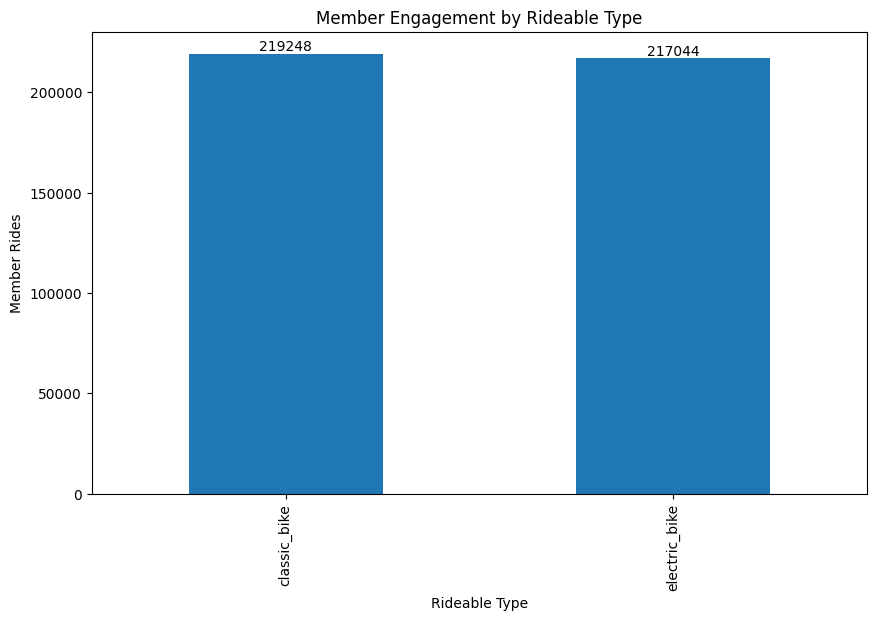

In [15]:
# Trend 1: Member Engagement Across Rideable Types
# Insight: Electric bikes and classic bikes consistently attract members.
member_rides_by_type = data[data['member_casual'] == 'member'].groupby('rideable_type')['member_casual'].count()
ax = member_rides_by_type.plot(kind='bar', figsize=(10, 6))  # Set the figure size if needed

plt.title('Member Engagement by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Member Rides')

# Add labels to each bar
for index, value in enumerate(member_rides_by_type):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

 


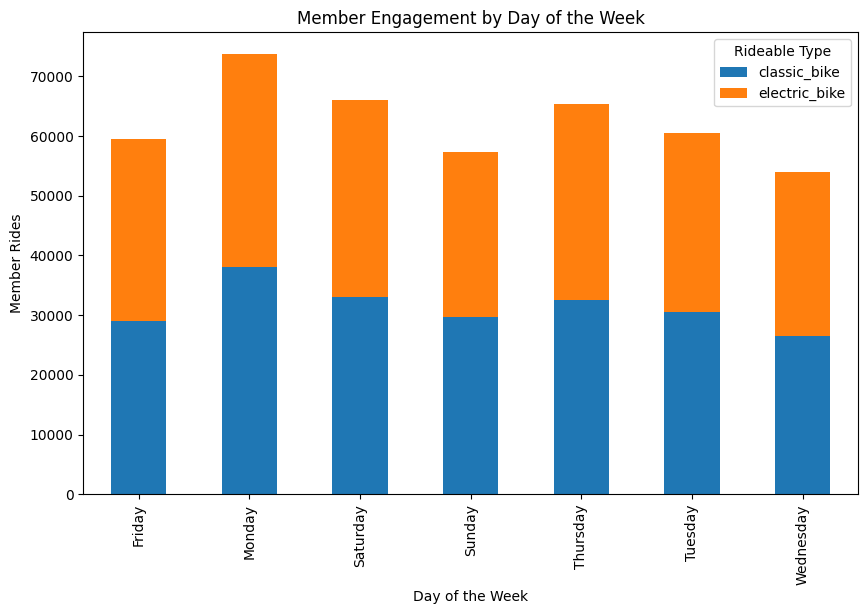

In [22]:
# Trend 2: Weekend Member Dominance
# Insight: Weekends see more member engagement, especially for classic and electric bikes.
member_rides_by_day = data[data['member_casual'] == 'member'].groupby(['weekday', 'rideable_type'])['member_casual'].count().unstack()
ax = member_rides_by_day.plot(kind='bar', stacked=True, figsize=(10, 6))  # Set the figure size if needed

plt.title('Member Engagement by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Member Rides')
plt.legend(title='Rideable Type')


plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_8376\699876149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casual_riders['ride_duration_category'] = casual_riders['ride_duration'].apply(categorize_duration)


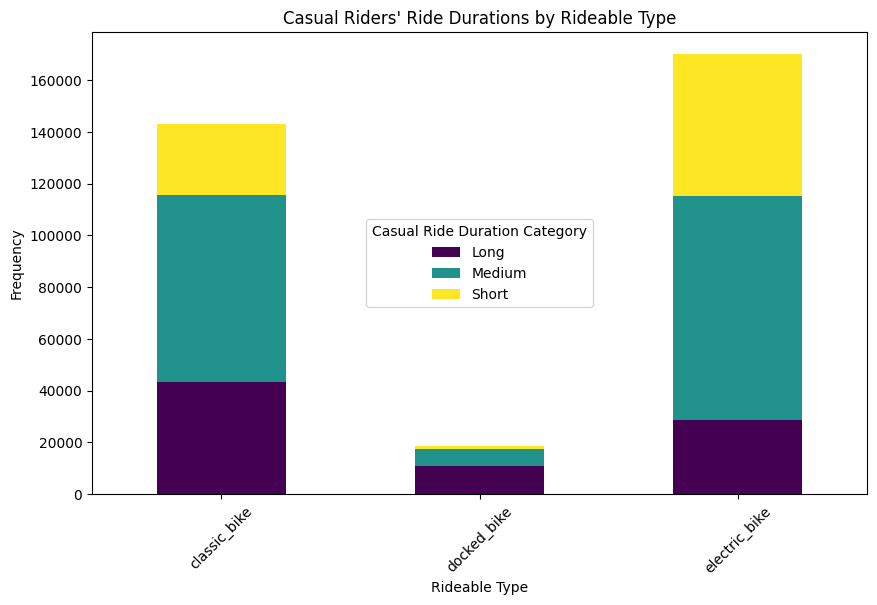

In [25]:
# Trend 3: Casual Riders' Ride Durations
# Insight: Casual riders using docked bikes tend to have longer ride durations.

# Calculate ride duration percentiles
casual_ride_duration_percentiles = casual_riders['ride_duration'].quantile([0.25, 0.5, 0.75])

# Create a function to categorize ride durations based on percentiles
def categorize_duration(duration):
    if duration <= casual_ride_duration_percentiles[0.25]:
        return 'Short'
    elif duration <= casual_ride_duration_percentiles[0.75]:
        return 'Medium'
    else:
        return 'Long'

# Create a new column 'ride_duration_category' based on percentiles using .loc
casual_riders['ride_duration_category'] = casual_riders['ride_duration'].apply(categorize_duration)

# Group data by 'rideable_type' and 'ride_duration_category', then count frequencies
grouped_data = casual_riders.groupby(['rideable_type', 'ride_duration_category']).size().unstack(fill_value=0)

# Create a combined bar chart
ax = grouped_data.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))

plt.title("Casual Riders' Ride Durations by Rideable Type")
plt.xlabel('Rideable Type')
plt.ylabel('Frequency')
plt.legend(title='Casual Ride Duration Category', loc='center')
plt.xticks(rotation=45)


plt.show()


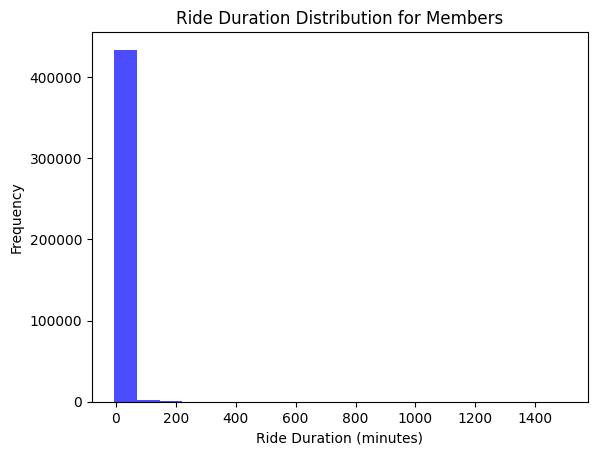

In [9]:
# Trend 4: Short Ride Durations and Member Preference
# Insight: Members prefer shorter rides.
member_ride_durations = data[data['member_casual'] == 'member']['ride_duration']
plt.hist(member_ride_durations, bins=20, color='blue', alpha=0.7)
plt.title('Ride Duration Distribution for Members')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Frequency')
plt.show()



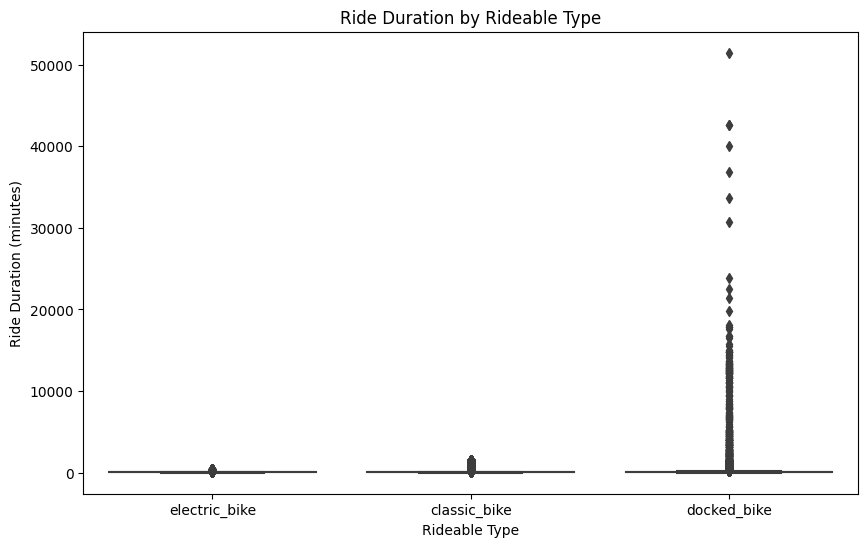

In [26]:
# Trend 5: Conversion Through Ride Speed and Duration
# Insight: Casual riders perceive electric bikes and classic bikes as faster options due to shorter ride durations.
plt.figure(figsize=(10, 6))
sns.boxplot(x='rideable_type', y='ride_duration', data=data)
plt.title('Ride Duration by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Ride Duration (minutes)')
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_8376\2724728222.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_members['ride_duration_category'] = annual_members['ride_duration'].apply(categorize_duration)


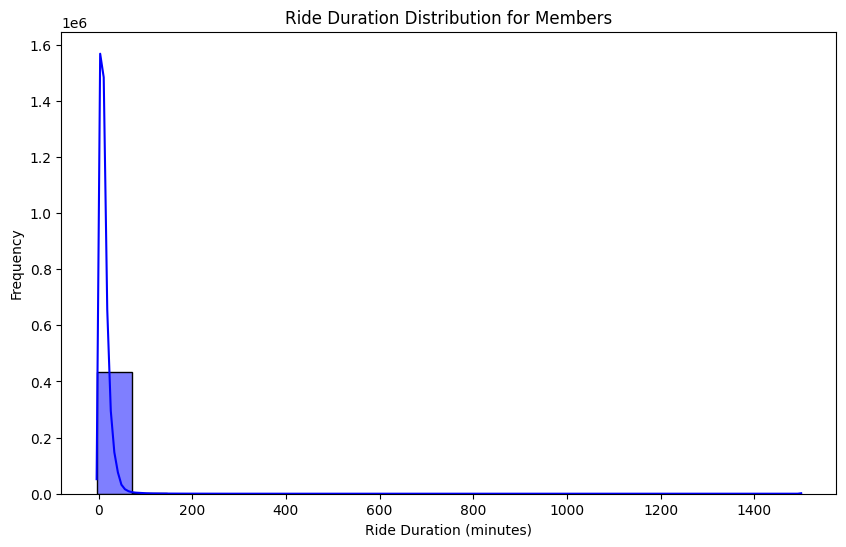

In [27]:
# Trend 6: Member Benefits
# Insight: Members prefer short ride durations, emphasizing the need for benefits aligned with quick rides.

# Calculate ride duration percentiles
ride_duration_percentiles = annual_members['ride_duration'].quantile([0.25, 0.5, 0.75])

# Create a function to categorize ride durations based on percentiles
def categorize_duration(duration):
    if duration <= ride_duration_percentiles[0.25]:
        return 'Short'
    elif duration <= ride_duration_percentiles[0.75]:
        return 'Medium'
    else:
        return 'Long'

# Create a new column 'ride_duration_category' based on percentiles using .loc
annual_members['ride_duration_category'] = annual_members['ride_duration'].apply(categorize_duration)

# Create a histogram to visualize ride duration distribution for members
plt.figure(figsize=(10, 6))
sns.histplot(data[data['member_casual'] == 'member']['ride_duration'], bins=20, kde=True, color='blue')
plt.title('Ride Duration Distribution for Members')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

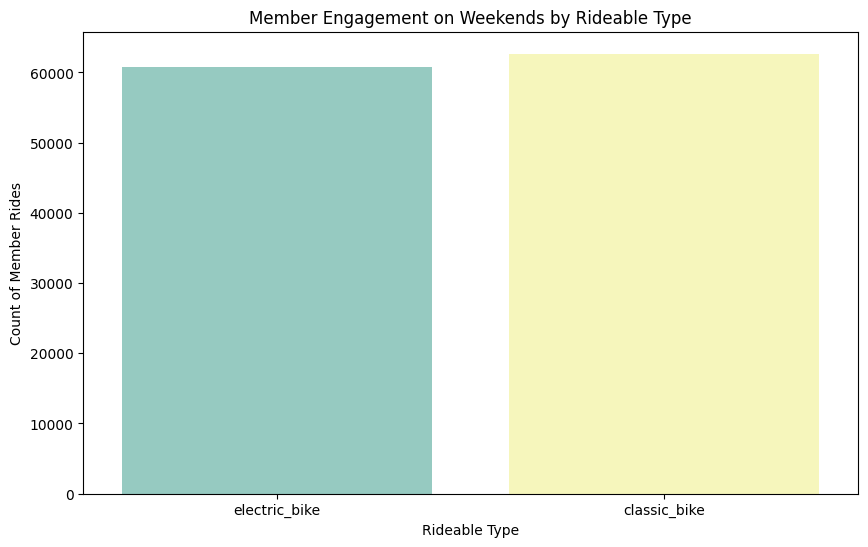

In [12]:
# Trend 7: Weekend Conversion Initiatives
# Insight: Member engagement peaks on weekends, making it a prime time for conversion efforts.

# Filter data for weekend member rides
weekend_member_rides = data[(data['member_casual'] == 'member') & (data['weekday'].isin(['Saturday', 'Sunday']))]

# Create a countplot to visualize member engagement on weekends by rideable type
plt.figure(figsize=(10, 6))
sns.countplot(x='rideable_type', data=weekend_member_rides, palette="Set3")
plt.title('Member Engagement on Weekends by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Count of Member Rides')
plt.show()
